# Прогнозирование оттока клиентов оператора связи «Ниединогоразрыва.ком»

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL или оптоволоконный кабель.  

Также доступны услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.   

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Требуется подготовить прототип модели машинного обучения, которая должна предсказать вероятность ухода клиента. Следует использовать в качестве основной метрики: ROC-AUC, которая должна быть больше 0,75. Модель поможет удержать клиентов тем самым избежать падение прибыли компании.

In [ ]:
# [To some Internal Section](#section_i) - ссылка
# <a id='section_id'></a> - написать после оглавления

# [Перейти к Заголовку 1](#title1)
# ## <a id="title1">Заголовок 1</a>

# Содержание проекта    

[Import](#Import)

[Импорт библиотек](#1)   
**Обзор данных**   
**Анализ данных**   
**Предобработка данных**  
  - изменение типа данных
   - обединение таблиц   
  - заполнение пропусков      
  - генерация новых признаков 
  - удаленее лишних признаков
  
**Исследовательский анализ данных**    
  - распределение признаков, построение графиков  
  - корреляция признаков / удаление коррелирующих признаков
  - исследование баланса классов
  
**Обучение моделей** 
  - разбиение выборки на тестовую и обучающую
  - LogisticRegression:
  - KNeighborsClassifier (возможно)
    - обработка переменных:убрать выбросы если есть, масштабирование, OneHotEncoder, определение важности признаков  
    - подбор гипперпараметров при помощи RandomizedSearchCV, обучение модели на кросс валидации, построения графика ROC-AUC
  - Random Forest:
    - определение важности признаков
    - подбор гипперпараметров при помощи RandomizedSearchCV, обучение модели на кросс валидации, построения графика ROC-AUC
  - CatBoostClassifier:
    - определение важности признаков
    - подбор гипперпараметров при помощи RandomizedSearchCV, обучение модели на кросс валидации, построения графика ROC-AUC
    - подведение итогов и выбор лучшей модели для теста
    
**Тестирование модели**   
**Вывод**   

---

# Import

# Импорт библиотек <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
import math
import numpy as np
import datetime as dt

try:
    import phik
except ModuleNotFoundError:
    !pip install phik
    import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
    
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings

try:
    import eli5
except ModuleNotFoundError:
    !pip install eli5
    import eli5

# Предварительная оценка    

Зарузим датасеты:

In [2]:
laptop_path = '/Users/avkor/JupyterProject/final_project/data'

In [ ]:
contract = pd.read_csv(laptop_path+'/contract.csv')
internet = pd.read_csv(laptop_path+'/internet.csv')
personal = pd.read_csv(laptop_path+'/personal.csv')
phone = pd.read_csv(laptop_path+'/phone.csv')

Посмотрим на предоставленные данные:

contract.csv — информация о договоре

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Колонка MonthlyCharges имеет числовое значения, все остальные - текстовое. В столбце TotalCharges следует изменить тип данных на числовой. Столбец EndDate следует преобразовать в целевой признак.

**internet.csv — информация об интернет-услугах**

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Дата фрейм internet имеет 5517 строк, меньше, чем количество уникальных абонентов

**personal.csv — персональные данные клиента**

In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**phone.csv — информация об услугах телефонии**

In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В данном датасете строк так же меньше, чем количество уникальных абонентов.

**При первичном исследование датафреймов мы увидили, что количество строк в датафреймах различаются, следовательно, при объединение данных появятся пропуски. Так же следует изменить тип данных некоторых переменных и создать целевой признак из столбца EndDate - датафрейм contract.**

# Анализ данных

Посмотрим все ли значения customerID уникальные в датасете 'contract':

In [15]:
len(contract) == contract.customerID.nunique()

True

Повторов нет.

Посмотрим какие значения в столбце SeniorCitizen (датасет 'personal'):

In [16]:
personal.SeniorCitizen.unique()

array([0, 1], dtype=int64)

В столбце два значения 0 или 1, является ли абонент пенсионером.

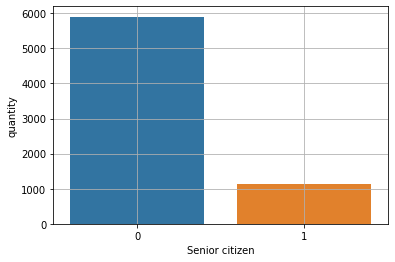

In [17]:
ax = sns.barplot(x=personal.SeniorCitizen.value_counts().index,
                 y=personal.SeniorCitizen.value_counts()
                )
ax.set_ylabel('quantity')
ax.set_xlabel('Senior citizen')
ax.grid()

Как мы видим, пенсионеров значительно меньше.

Посмотрим на распределение признака MultipleLines (наличие возможности ведения параллельных линий во время звонка) - датасет phone:

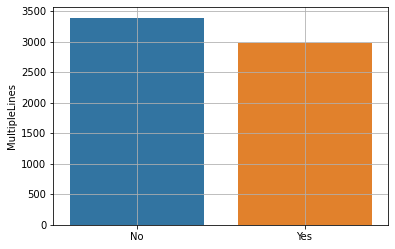

In [18]:
ax = sns.barplot(x=phone.MultipleLines.value_counts().index,
                 y=phone.MultipleLines.value_counts())
ax.grid();

Значения распределены почти одинаково.

Создадим словарь df_dict: имя датасета - датасет, для дальнейшего анализа

In [19]:
df_dict = {'contract': contract, 'personal': personal,
           'internet': internet, 'phone': phone}

Посмотрим есть ли пропуски и явные дубликаты в датасетах: 

In [20]:
for key, value in dict.items(df_dict):
    print('      ', key)
    print('               пропуски')
    print(value.isna().sum())
    print()
    print('дубликаты      ', value.duplicated().sum())
    print('--------------------------')
    

       contract
               пропуски
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

дубликаты       0
--------------------------
       personal
               пропуски
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

дубликаты       0
--------------------------
       internet
               пропуски
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

дубликаты       0
--------------------------
       phone
               пропуски
customerID       0
MultipleLines    0
dtype: int64

дубликаты       0
--------------------------


Пропусков и дубликатов не обнаружено.

Проверим все ли значеня в столбце customerID в каждом датасете уникальны:

In [21]:
for key, value in df_dict.items():
    print(key)
    print(value.customerID.nunique() != value.shape[0])
    print('--------')
    

contract
False
--------
personal
False
--------
internet
False
--------
phone
False
--------


Все значения уникальные

Рассмотрим столбец EndDate (дата окончания пользования услугами), датасет contract:

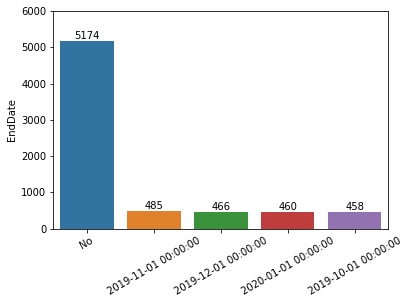

In [22]:
ax = sns.barplot(
    x=contract.EndDate.value_counts().index,
    y=contract.EndDate.value_counts()
)
plt.xticks(rotation=30)
plt.bar_label(ax.containers[0])
plt.ylim(0, 6000);

Анализ показал, что абоненты начали уходить с октября 2019-го, то есть последние 4 месяца. 

In [23]:
contract[contract.EndDate != 'No'].count()[0]

1869

И за все время ушло 1869 абонентов.

**Предварительный анализ показал что в исходных данных нет пропусков, ID клиента не повторяются, так же мы выяснили, что пользователи стали уходить последние 4 месяца относительно даты выгрузки (примерно одинаковое количество каждый месяц).**

# Предобработка данных

Изменим тип данных в столбце BeginDate - датасет contract на datetime:

In [24]:
contract.BeginDate = pd.to_datetime(contract.BeginDate, format='%Y-%m-%d').dt.date

Создадим новый столбец с целевым признаком, где 0 - абонент пользуется услугами компании, 1 - перестал пользоваться:

In [25]:
contract['target'] = np.where(contract['EndDate'] == 'No', 0, 1)

Заменим значение 'No' в столбце EndDate датасет contract на дату выгрузки данных '2020-02-01'

In [26]:
contract.loc[contract.EndDate == 'No', 'EndDate'] = '2020-02-01'

Изменим тип данных в столбце EndDate на datetime:

In [27]:
contract.EndDate = pd.to_datetime(contract.EndDate, format='%Y-%m-%d').dt.date

In [28]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Создадим новый признак: day_of_use - количество дней которые абонент пользуется / пользовался услугами компании:

In [29]:
contract['day_of_use'] = (
    contract['EndDate'] - contract['BeginDate']
    ).astype('timedelta64[D]').astype('int')

In [30]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day_of_use
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [31]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   target            7043 non-null   int32  
 9   day_of_use        7043 non-null   int32  
dtypes: float64(1), int32(2), object(7)
memory usage: 495.3+ KB


Изменим тип данных в столбце TotalCharges (всего потрачено денег на услуги) на 'float':

In [32]:
# contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Выдает ошибку, в столбце есть строковый объект - ' ', выясним количество и закономерность:

In [33]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day_of_use
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


Предположим, что пустые значения в столбце TotalCharges это 0, так как абонент стал пользоваться услугами компании в месяц выгрузки данных и оплата еще не поступила. Поверим предположение и выясним есть ли еще строки с датой начало пользования услугами - '2020-02-01' и посмотрим на значения в столбце TotalCharges:

In [34]:
contract[(contract['TotalCharges'] != ' ') & (contract['BeginDate'] == '2020-02-01')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day_of_use


Предположение подтвердилось. Заполним пропуски значением ежемесячного платежа в столбце contract.TotalCharges:

In [35]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']

Преобразуем формат столбца contract.TotalCharges в float:

In [36]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Еще раз проверим пропуски в таблице contract:

In [37]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
day_of_use          0
dtype: int64

Пропусков нет

Создадим допоплнительные переменные: пользователи телефонии и интернета в датафрейме phone и internet - столбецы со значением 'Yes':

In [38]:
phone['phone'] = 'Yes'
internet['internet'] = 'Yes'

Соединим все таблицы при помощи метода merge по столбцу customerID:

In [39]:
df1 = pd.merge(contract, internet, how='outer', on='customerID')

In [40]:
df2 = pd.merge(df1, personal, how='outer', on='customerID')

In [41]:
df_all = pd.merge(df2, phone, how='outer', on='customerID')

In [42]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   target            7043 non-null   int32  
 9   day_of_use        7043 non-null   int32  
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null   object 


Проверим пропуски в полученном датасете:

In [43]:
df_all.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
day_of_use             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
internet            1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
phone                682
dtype: int64

Количество пропусков должно соответствовать разнице числа строк с датасетом contract:

In [44]:
for key, value in df_dict.items():
    print(key)
    print(contract.shape[0] - value.shape[0])

contract
0
personal
0
internet
1526
phone
682


Все так

Проверим количество уникальных ID в столбце customerID, должно быть 7043:

In [45]:
df_all.customerID.nunique()      

7043

Все ок

Заменим все пропуски в датасете df_all на 'No':

In [46]:
df_all = df_all.fillna('No')

In [47]:
df_all.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
day_of_use          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
internet            0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
phone               0
dtype: int64

In [48]:
df_all.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day_of_use,...,TechSupport,StreamingTV,StreamingMovies,internet,gender,SeniorCitizen,Partner,Dependents,MultipleLines,phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,No,No,No,Yes,Female,0,Yes,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,No,Yes,Male,0,No,No,No,Yes
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,No,Yes,Male,0,No,No,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,Yes,No,No,Yes,Male,0,No,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,No,Yes,Female,0,No,No,No,Yes


Посмотрим на распределение количества дней использования услуг:

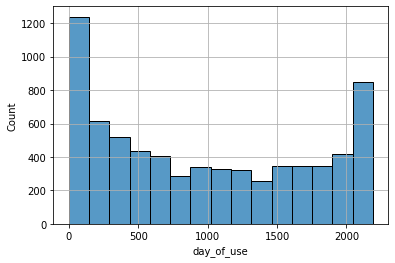

In [49]:
axe = sns.histplot(df_all.day_of_use)
plt.grid()
plt.show()

Мы видим, что преобладает количество абонентов, которые пользуются услугами менее 150 дней и более 2000 дней. 

In [50]:
df_all.day_of_use.describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: day_of_use, dtype: float64

Посмотрим на распределение количества дней использования услуг ушедшими пользователями:

In [51]:
bins=20

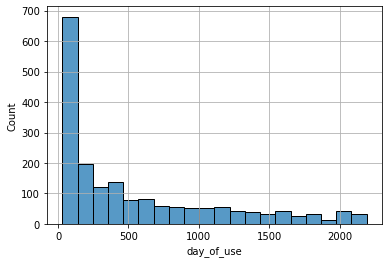

In [52]:
sns.histplot(df_all[df_all.target == 1]['day_of_use'], bins=bins)
plt.grid()
plt.show()

In [53]:
min_day, max_day = (df_all[df_all.target == 1]['day_of_use'].min(),
                   df_all[df_all.target == 1]['day_of_use'].max())
(max_day - min_day) / bins

108.05

Ушли в основном те, кто пользовался услугами меньше 110 дней.

Посмотрим на время пользования услугами абонентов которые остались:

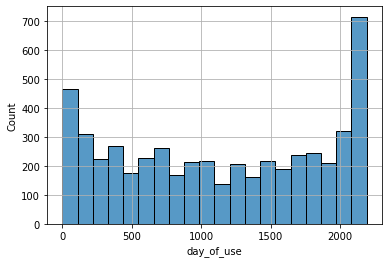

In [54]:
sns.histplot(df_all[df_all.target == 0]['day_of_use'], bins=bins)
plt.grid()
plt.show()

In [55]:
min_day, max_day = (df_all[df_all.target == 0]['day_of_use'].min(),
                   df_all[df_all.target == 0]['day_of_use'].max())
(max_day - min_day) / bins

109.55

Мы видим два максимума, наибольший это самые первые клиенты - пользовались услугами больше 2000 дней и клиенты, пользующиеся услугами, меньше 110 дней.

Посмотри на медиану использования услуг по дням в двух группах:

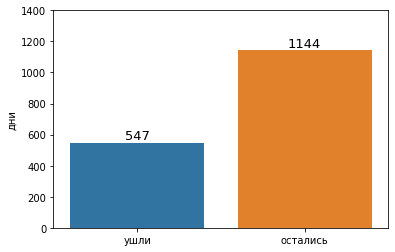

In [56]:
stay = df_all[df_all.target == 1]['day_of_use'].mean()
gone = df_all[df_all.target == 0]['day_of_use'].mean()
sns.barplot(x=['ушли', 'остались'],
            y=[stay, gone])
for i, val in enumerate([stay, gone]):
    plt.text(i, val+1, round(val), ha='center',
             va='bottom', fontdict={'weight':500, 'size':13})
plt.ylabel('дни')
plt.ylim([0, 1400]);

Мы видим, что значение медианы (количество дней пользования услугами) для покинувших компанию в два раза меньше.

Исходя из проведенного анализа, можно сделать предположение: чем меньше времени абонент пользуется услугами компании, тем больше вероятность, что он расторгнет контракт.

Посмотрим как менялся средний месячный платеж за услуги в зависимости от даты начала пользования:

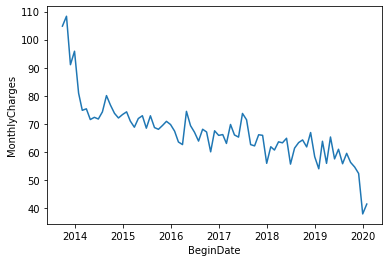

In [57]:
plt.plot(df_all.groupby('BeginDate')['MonthlyCharges'].mean())
plt.xlabel('BeginDate')
plt.ylabel('MonthlyCharges')
plt.show()

Мы видим тенденцию на снижение среднемесячного платежа за услуги.

Посмотрим сколько в среднем платят ушедшие и лояльные клиенты:

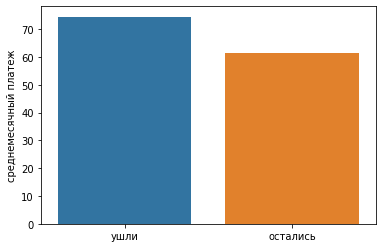

In [58]:
sns.barplot(x=['ушли', 'остались'],
    y=[df_all[df_all['target'] == 1]['MonthlyCharges'].mean(),
         df_all[df_all['target'] == 0]['MonthlyCharges'].mean()])
plt.ylabel('среднемесячный платеж');

Мы видим, что среднемесячный платеж у ушедших клиентов выше, чем у лояльных.

Удалим столбцы BeginDate, EndDate для модели они не пригодятся, колонку customerID сделаем индексом:

In [59]:
df_mod = df_all.drop(['BeginDate', 'EndDate'], axis=1)
df_mod = df_mod.set_index('customerID')

In [60]:
df_mod.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day_of_use,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,internet,gender,SeniorCitizen,Partner,Dependents,MultipleLines,phone
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,DSL,No,Yes,...,No,No,No,Yes,Female,0,Yes,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,DSL,Yes,No,...,No,No,No,Yes,Male,0,No,No,No,Yes
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,DSL,Yes,Yes,...,No,No,No,Yes,Male,0,No,No,No,Yes
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,DSL,Yes,No,...,Yes,No,No,Yes,Male,0,No,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Fiber optic,No,No,...,No,No,No,Yes,Female,0,No,No,No,Yes


In [61]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   target            7043 non-null   int32  
 6   day_of_use        7043 non-null   int32  
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  internet          7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null 

Создадим списки категориальных и числовых переменных:

In [62]:
numeric_col = ['MonthlyCharges', 'TotalCharges', 'day_of_use']

In [63]:
categorical_col = df_mod.columns[(
    ~df_mod.columns.isin(numeric_col)) & (
    df_mod.columns != 'target')]
categorical_col

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'internet', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'MultipleLines', 'phone'],
      dtype='object')

Проверим числовые переменные на наличие выбросов:

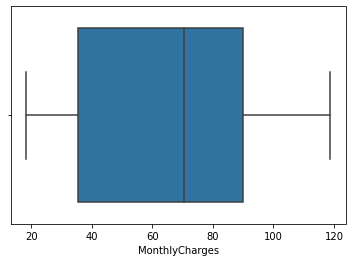

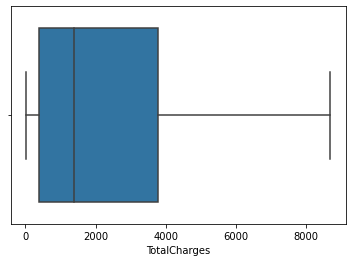

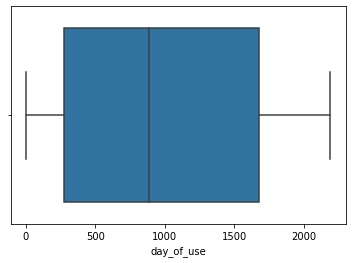

In [64]:
for col in numeric_col:
    sns.boxplot(x=df_mod[col])
    plt.show()

Выбросов нет.

**Корреляция:**

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'day_of_use', 'SeniorCitizen']
interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'day_of_use', 'SeniorCitizen']
interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'day_of_use', 'SeniorCitizen']


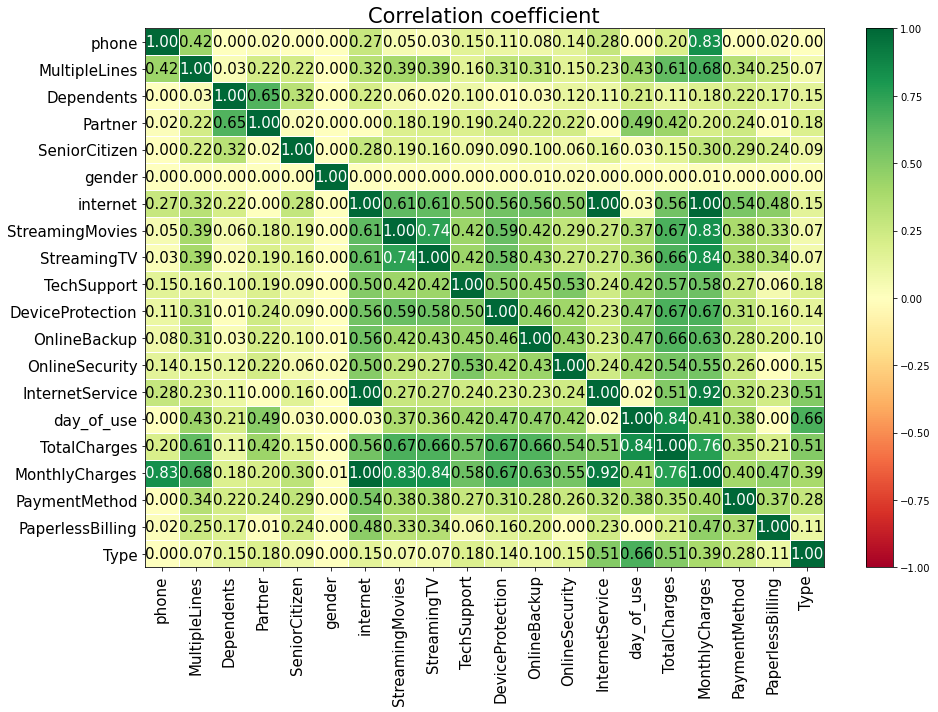

In [65]:
c = df_mod[df_mod.columns[df_mod.columns != 'target']]
plot_correlation_matrix(c.phik_matrix().values, 
                        x_labels=c.phik_matrix().columns, 
                        y_labels=c.phik_matrix().index, 
                        vmin=-1, vmax=1, title="Сorrelation coefficient", 
                        usetex=False, fontsize_factor=1.5, figsize=(14, 10));
plt.tight_layout()
plt.show()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'day_of_use', 'SeniorCitizen']
interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'day_of_use', 'SeniorCitizen']
interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'day_of_use', 'SeniorCitizen']


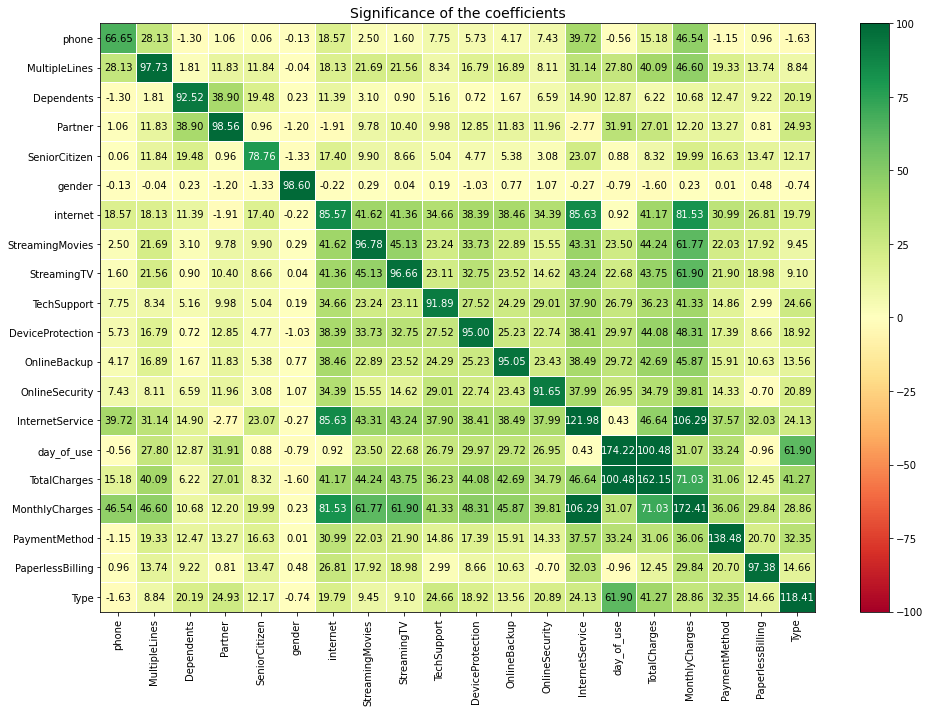

In [66]:
plot_correlation_matrix(c.significance_matrix().values, 
                        x_labels=c.significance_matrix().columns, 
                        y_labels=c.significance_matrix().index, 
                        vmin=-100, vmax=100, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(14, 10))
plt.tight_layout()

В итоге удалим столбцы, которые имеют коэффициент корреляции больше 80 со следующими признаками:  
MonthlyCharges с phone, internet, StreamingMovies, StreamingTV, InternetService;   
TotalCharges с day_of_use;  
internet с InternetService.

In [67]:
df_lin = df_mod.drop(['MonthlyCharges', 'TotalCharges', 'internet'], axis=1)

Проверим баланс классов:

In [68]:
(df_lin.target == 1).sum(), (df_lin.target == 0).sum()

(1869, 5174)

Мы видим, что есть дисбаланс классов по целевому признаку, исправим это внутри модели.

**В итоге была проведена предобработка данных, был изменен тип некоторых признаков, заполнены пропуски, были созданы новые признаки. Произвели объединение таблиц и так же заполнили полученные пропуски. Проведен анализ распределения клиентов по месяцам использования услуг компании. Проверили числовые признаки на выбросы. Провели анализ кореллирующих признаков и для линейных моделей были удалены несколько признаков. Обнаружен дисбаланс классов по целевому признаку.**

# Обучение модели

Обучим и сравним качество следующих моделей: LogisticRegression, KNeighborsClassifier, RandomForestClassifier, CatBoostClassifier, LGBMClassifier.

Создадим списки с категориальными и числовыми переменными для регресси и к-ближайших соседей:

In [69]:
df_lin.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'target', 'day_of_use',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'phone'],
      dtype='object')

In [70]:
numeric_col = ['day_of_use']

In [71]:
categorical_col = df_lin.columns[(
    ~df_lin.columns.isin(numeric_col)) & (
    df_lin.columns != 'target')]
categorical_col

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'phone'],
      dtype='object')

Разделим данные для регресси и к-ближайших соседей на признаки и целевые признаки: 

In [72]:
X, y = df_lin.drop(['target'], axis=1), df_lin['target']

Разделим данные на обучающую и тестовую выборки:

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25,
    stratify=y,
    random_state=141122
)

## LogisticRegression

In [80]:
preprocessing = ColumnTransformer([("numeric", Pipeline(
    [("scale", StandardScaler())]), numeric_col),
                                   ("categorical", Pipeline(
    [("ohe", OneHotEncoder(drop="first"))]), categorical_col)])

pipe = Pipeline(
    [("preprocessing", preprocessing), ("classifier", LogisticRegression(random_state=141122))])

In [91]:
param_grid = [{
        'classifier__C': np.arange(2, 7, .2),
        'classifier__class_weight': ['balanced'],
    }]

In [92]:
search = GridSearchCV(pipe, param_grid, cv=5, verbose=3, scoring='roc_auc', n_jobs=-1,)

In [93]:
lr_grid = search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [94]:
lr_grid.best_score_

0.8429581752262851

In [95]:
lr_grid.best_params_

{'classifier__C': 4.600000000000002, 'classifier__class_weight': 'balanced'}

Модель LogisticRegression показала roc_auc = 0.843

## KNeighborsClassifier

In [96]:
preprocessing = ColumnTransformer(
    [("numeric", Pipeline([("scale", StandardScaler())]), numeric_col),
     ("categorical", Pipeline([("ohe", OneHotEncoder(
         drop="first", sparse=False))]), categorical_col)])

pipe = Pipeline(
    [("preprocessing", preprocessing), ("classifier", KNeighborsClassifier())])

In [127]:
param_grid = [{
        'classifier__weights': ['uniform'],
        'classifier__n_neighbors':  range(56, 66, 2),
        'classifier__p': [3,4,5],
        'classifier': [KNeighborsClassifier()]
    }]

In [128]:
search = GridSearchCV(pipe, param_grid, cv=5, verbose=3, scoring='roc_auc', n_jobs=-1,)

In [129]:
KNS_grid = search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [130]:
KNS_grid.best_score_

0.8383015634253848

In [131]:
KNS_grid.best_params_

{'classifier': KNeighborsClassifier(n_neighbors=58, p=4),
 'classifier__n_neighbors': 58,
 'classifier__p': 4,
 'classifier__weights': 'uniform'}

Модель KNeighborsClassifier показала roc_auc = 0.838

## RandomForestClassifier

Разделим данные для RandomForest и бустинга на признаки и целевые признаки:

In [132]:
X, y = df_mod.drop(['target'], axis=1), df_mod['target']

Разделим данные на обучающую и тестовую выборки:

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25,
    stratify=y,
    random_state=141122
)

In [134]:
numeric_col = ['MonthlyCharges', 'day_of_use', 'TotalCharges']

In [135]:
categorical_col = df_mod.columns[(
    ~df_mod.columns.isin(numeric_col)) & (
    df_mod.columns != 'target')]
categorical_col

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'internet', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'MultipleLines', 'phone'],
      dtype='object')

In [136]:
preprocessing = ColumnTransformer([
         ("numeric", Pipeline([("scale", StandardScaler())]), numeric_col),
     ("categorical", Pipeline([("ohe", OneHotEncoder(
         drop="first", sparse=False))]), categorical_col)])

pipe = Pipeline(
    [("preprocessing", preprocessing), ("classifier", RandomForestClassifier(random_state=141122))]
)

In [149]:
param_grid = [{
        'classifier__class_weight': ['balanced'],
        'classifier__n_estimators': range(110, 210, 10),
        'classifier__min_samples_split': (20, 50, 2),
        'classifier__min_samples_leaf': range(2, 6, 2),
        'classifier__max_depth': range(30, 38, 2),
    }]

In [151]:
search = RandomizedSearchCV(
    pipe, param_grid, cv=5, verbose=3, scoring='roc_auc',
    n_jobs=-1, random_state=141122, n_iter=10
)

In [152]:
RFC_grid = search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [153]:
RFC_grid.best_score_

0.8581472075980482

In [154]:
RFC_grid.best_params_

{'classifier__n_estimators': 190,
 'classifier__min_samples_split': 50,
 'classifier__min_samples_leaf': 2,
 'classifier__max_depth': 34,
 'classifier__class_weight': 'balanced'}

Модель RandomForestClassifier показала roc_auc = 0.858

## CatBoostClassifier

In [155]:
preprocessing = ColumnTransformer([
        ("numeric", Pipeline([("scale", StandardScaler())]), numeric_col),
     ("categorical", Pipeline([("ohe", OneHotEncoder(
         drop="first", sparse=False))]), categorical_col)
])

pipe = Pipeline(
    [("preprocessing", preprocessing),
     ("classifier", CatBoostClassifier(
#           cat_features = categorical_col,
            verbose=100,
            random_state=141122,
        eval_metric='AUC'))])

In [156]:
param_grid = [{
    'classifier__iterations': [1000],
    'classifier__depth': range(2, 6, 2),
    'classifier__l2_leaf_reg': range(1, 4, 1),
    'classifier__learning_rate': [.03],
    }]

In [157]:
search = GridSearchCV(pipe, param_grid, cv=5, verbose=100, scoring='roc_auc', n_jobs=-1,)

In [158]:
# search = RandomizedSearchCV(
# pipe, param_grid, cv=5, verbose=3, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=141122
# )

In [159]:
CBC_grid = search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	total: 156ms	remaining: 2m 35s
100:	total: 721ms	remaining: 6.42s
200:	total: 1.31s	remaining: 5.22s
300:	total: 1.88s	remaining: 4.37s
400:	total: 2.46s	remaining: 3.67s
500:	total: 3.03s	remaining: 3.02s
600:	total: 3.61s	remaining: 2.39s
700:	total: 4.18s	remaining: 1.78s
800:	total: 4.75s	remaining: 1.18s
900:	total: 5.32s	remaining: 584ms
999:	total: 5.9s	remaining: 0us


In [160]:
CBC_grid.best_score_

0.9091720999585953

In [161]:
CBC_grid.best_params_

{'classifier__depth': 4,
 'classifier__iterations': 1000,
 'classifier__l2_leaf_reg': 1,
 'classifier__learning_rate': 0.03}

Модель CatBoostClassifier показала roc_auc = 0.91

## LGBMClassifier


In [162]:
preprocessing = ColumnTransformer([
     ("numeric", Pipeline([("scale", StandardScaler())]), numeric_col),
     ("categorical", Pipeline([("ohe", OneHotEncoder(
         drop="first", sparse=False))]), categorical_col)])

pipe = Pipeline(
    [("preprocessing", preprocessing),
     ("classifier", LGBMClassifier(
            class_weight='balanced',
            random_state=141122))])

In [163]:
param_grid = [{
    'classifier__n_estimators': [1500],
    'classifier__boosting_type': ['gbdt'],
    'classifier__max_depth': range(1,3),
    'classifier__num_leaves': [100, 200]
    }]

In [165]:
search = GridSearchCV(pipe, param_grid, cv=5, verbose=100, scoring='roc_auc', n_jobs=-1,)

In [166]:
LGBMC_grid = search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [167]:
LGBMC_grid.best_score_

0.9108672510076049

In [168]:
LGBMC_grid.best_params_

{'classifier__boosting_type': 'gbdt',
 'classifier__max_depth': 2,
 'classifier__n_estimators': 1500,
 'classifier__num_leaves': 100}

Модель LGBMClassifier показала roc_auc = 0.91

In [169]:
total = pd.DataFrame({
    'roc_auc_score': 
    [lr_grid.best_score_, KNS_grid.best_score_ , RFC_grid.best_score_,
     LGBMC_grid.best_score_, CBC_grid.best_score_]},
    index=['LogisticRegression', 'KNeighborsClassifier',
           'RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier'])
total.sort_values('roc_auc_score', ascending=False)

,roc_auc_score
LGBMClassifier,0.910867
CatBoostClassifier,0.909172
RandomForestClassifier,0.858147
LogisticRegression,0.842958
KNeighborsClassifier,0.838302


LGBMClassifier	0.911  
CatBoostClassifier	0.909  
RandomForestClassifier	0.858  
LogisticRegression	0.843  
KNeighborsClassifier	0.838  

В итоге мы проверили 5 моделей из которых LGBMClassifier показала лучший результат.

In [170]:
best_model = LGBMC_grid.best_estimator_

## Повышение качества модели

Определим наиболее важные признаки для модели, менее важные удалим и обучим модель на урезанном датафрейме, посмотрим как изменится качество:

In [172]:
onehot_columns = list(
    best_model.named_steps['preprocessing']
    .named_transformers_['categorical'].named_steps['ohe']
    .get_feature_names_out(input_features=categorical_col))

features_list = list(numeric_col)
features_list.extend(onehot_columns)

In [173]:
eli5.explain_weights(best_model.named_steps['classifier'], top=24,
                     feature_names=features_list)

Weight,Feature
0.5173,day_of_use
0.1295,Type_Two year
0.0877,InternetService_Fiber optic
0.0481,Type_One year
0.0459,TotalCharges
0.0432,MonthlyCharges
0.0342,PaymentMethod_Electronic check
0.0327,InternetService_No
0.0090,PaperlessBilling_Yes
0.0077,StreamingTV_Yes


Мы видим, что можно удалить следующие признаки: OnlineBackup, PaymentMethod, DeviceProtection, internet.

In [222]:
cut = ['OnlineBackup', 'PaymentMethod', 'DeviceProtection', 'internet']

Удалим признаки:

In [223]:
X_train_cut = X_train.drop(cut, axis=1)

Создаим новый список категориальных признаков 

In [224]:
categorical_col_cat = categorical_col[~categorical_col.isin(cut)]
categorical_col_cat

Index(['Type', 'PaperlessBilling', 'InternetService', 'OnlineSecurity',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'phone'],
      dtype='object')

In [225]:
numeric_col

['MonthlyCharges', 'day_of_use', 'TotalCharges']

Обучим модель:

In [226]:
preprocessing = ColumnTransformer([
    ("numeric", Pipeline([("scale", StandardScaler())]), numeric_col),
     ("categorical", Pipeline([("ohe", OneHotEncoder(
         drop="first", sparse=False))]), categorical_col_cat)])

pipe = Pipeline(
    [("preprocessing", preprocessing),
     ("classifier", LGBMClassifier(
            class_weight='balanced',
            random_state=141122))])

In [227]:
param_grid = [{
    'classifier__n_estimators': [1500],
    'classifier__boosting_type': ['gbdt'],
    'classifier__max_depth': [2],
    'classifier__num_leaves': [100],
    }]

In [228]:
search_cut = GridSearchCV(pipe, param_grid, cv=5, verbose=100, scoring='roc_auc', n_jobs=-1,)

In [229]:
LGBMC_grid_cut = search_cut.fit(X_train_cut, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [230]:
LGBMC_grid_cut.best_score_

0.9124066049219335

In [231]:
best_model_cut = LGBMC_grid_cut.best_estimator_

В итоге удаление менее значимых признаков не значительно повысило качество модели.

# Тестирование модели

Проверим модель LGBMClassifier на тестовой выбоорке.

In [233]:
X_test = X_test.drop(cut, axis=1)

In [234]:
roc_auc_score(y_test, best_model_cut.predict_proba(X_test)[:,1])

0.9243014208221773

Полученный результат (ROC AUC = 0.924) выше результата, полученный на обучающей  выборке.

Построим ROC-кривую:

LGBMClassifier: ROC AUC=0.924


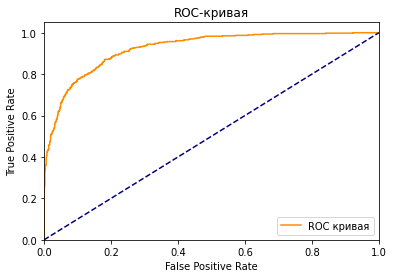

In [236]:
lr_probs = best_model_cut.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('LGBMClassifier: ROC AUC=%.3f' % (lr_auc))
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Посчитаем accuracy:

In [237]:
accuracy_score(y_test, best_model_cut.predict(X_test))

0.8472458830210108

Данная метрика показала (accuracy = 0.85), что наша модель выдает правильный результат в 85% случаев.

Построим матрицу ошибок

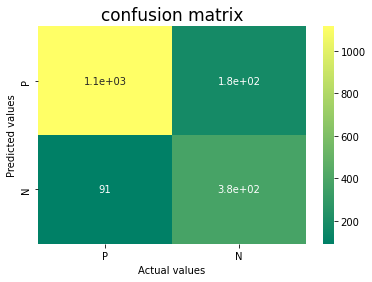

In [238]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, best_model_cut.predict(X_test)),
)

ax = sns.heatmap(
    df_cm, cmap='summer', annot=True, 
    xticklabels=['P','N'], yticklabels=['P','N'],    
)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('confusion matrix', size=17);

Мы видим, что модель предсказывает истинно положительных значений 1100, а ложно положительных 180, истинно отрицательных значений - 380.В нашем случае что выгодней предсказывать (истино положительные значения или истинно отрицательные значения) не понятно и поэтому стоит опираться на метрику ROC-AUC, которая показывает зависимость TPR (полноты) от FPR (доля отрицательных значений предсказанных не верно из отрицательных значений) при варьировании порога для бинаризации.

# ВЫВОД

В ходе нашего исследования была построена модель LGBMClassifier со следующими гиппер параметрами:   
* n_estimators 1500,
* boosting_type 'gbdt',
* max_depth 2,
* num_leaves 100.

Метрика ROC-AUC на тестовой выборке получилась 0,92.   
Данная модель может спрогнозировать, уйдет клиент из компании в ближайшее время или нет.

# Отчет по решению

**Исходные данные состояли из четырех файлов:**  
* contract.csv — информация о договоре;  
* personal.csv — персональные данные клиента;  
* internet.csv — информация об интернет-услугах;  
* phone.csv — информация об услугах телефонии.   

Отметим основные моменты работы:   
* **предварительный анализ исходных данных:** 
    - пропуски и дубликаты - не обнаружены;
* **предобработка данных:**
    - создали целевой признак target из столбца contract.EndDate, где 0 - абонент пользуется услугами компании, 1 - ушел;
    - в столбце contract.EndDate заменили значение 'No' на дату выгрузки данных, т.е. на '2020-02-01';
    - измененили типа данных в столбцах: contract.BeginDate и contract.EndDate на datetime;
    - создали новые признаки: day_of_use (количество месяцев которые абонент пользуется / пользовался услугами компании), phone (пользователи услугами телефонии, значения 'Yes'/'No') и internet (пользователи услугами интернета, значения 'Yes'/'No')
    - обнаружили строковые символы (' ') в столбце contract.TotalCharges и заменили их на значение ежемесячного платежа (contract.MonthlyCharges);
    - измененили типа данных в столбце contract.TotalCharges на 'float';
    - объединили все датафреймы и заменили полученные пропуски на 'No';
    - были удалены признаки BeginDate и EndDate;
    - проверили числовые признаки на наличие выбросов - не обнаружили;
    - для линейной модели и к-ближайших соседей проверили признаки на мультиколлинеарность и по итогам проверки были отобранны пары признаков коэффициент корреляции которых был больше 80, в итоге удалили следующие признаки 'MonthlyCharges', 'TotalCharges', 'internet' и создали отдельный датасет.
    - выяснили, что есть дисбаланс классов по целевому признаку.
    
* **обучение моделей:**
    - разделили данные без коррелирующих признаков ('Type', 'PaperlessBilling', 'PaymentMethod', 'target', 'day_of_use', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'phone') для регресси и к-ближайших соседей на признаки и целевые признаки;
    - разделили данные на обучающую и тестовую выборки в соотношение 0,75 и 0,25 соответственно;
    - были обучены и протестированны при помощи кроссвалидации модели LogisticRegression и KNeighborsClassifier; для обработки признаков использовали pipeline cо StandardScaler и OneHotEncoder, для обучения, подбора параметров и тестирования - GridSearchCV; использовали метрику ROC AUC, получили следующие результаты: для LogisticRegression - 0.843, для KNeighborsClassifier - 0.835;
    - разделили данные с коррелирующими признаками ('Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'internet', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'phone', 'MonthlyCharges', 'day_of_use', 'TotalCharges') для бустинга и деревьев на признаки и целевые признаки;
    - разделили данные на обучающую и тестовую выборки в соотношение 0,75 и 0,25 соответственно;
    - были обучены и протестированны при помощи кроссвалидации модели RandomForestClassifier, CatBoostClassifier и LGBMClassifier; для обработки признаков использовали pipeline c StandardScaler и OneHotEncoder, для обучения, подбора параметров и тестирования - GridSearchCV; использовали метрику ROC AUC, получили следующие результаты: для RandomForestClassifier - 0.859, для CatBoostClassifier -  0.909, для LGBMClassifier - 0.911;
* **повышение качества модели:**   
    - выбрали лучшую модель LGBMClassifier, для данной модели определили рейтинг важности признаков и удалили наименее важные: 'OnlineBackup', 'PaymentMethod', 'DeviceProtection', 'internet';
    - при помощи кроссвалидации обучили и протестировали модель LGBMClassifier на усеченном датафрейме; для обработки признаков использовали pipeline cо StandardScaler и OneHotEncoder, для обучения и тестирования - GridSearchCV; использовали метрику ROC AUC, получили результат 0,912;
* **тестирование модели:**
    - протестировали модель на тестовой выборке и получили результат ROC AUC = 0,924;
    - посчитали accuracy = 0,85;
    - построили ROC кривую, матрицу ошибок, провели анализ, написали вывод.